In [1]:
from google.colab import files


uploaded = files.upload()

Saving Google Scholar AI&ML Papers.csv to Google Scholar AI&ML Papers.csv


In [2]:
import pandas as pd
df = pd.read_csv("Google Scholar AI&ML Papers.csv")

In [3]:
df.columns

Index(['Title', 'Abstract', 'Authors', 'Year', 'URL', 'Citations', 'Journal',
       'Venue', 'Publication Types'],
      dtype='object')

In [22]:
df.head()

,Title,Abstract,Authors,Year,URL,Citations,Journal,Venue,Publication Types
0,Fashion-MNIST: a Novel Image Dataset for Bench...,"We present Fashion-MNIST, a new dataset compri...","Han Xiao, Kashif Rasul, Roland Vollgraf",2017,https://www.semanticscholar.org/paper/f9c602cc...,8315,ArXiv,arXiv.org,JournalArticle
1,TensorFlow: Large-Scale Machine Learning on He...,TensorFlow is an interface for expressing mach...,"Martín Abadi, Ashish Agarwal, P. Barham, E. Br...",2016,https://www.semanticscholar.org/paper/9c9d7247...,10959,ArXiv,arXiv.org,JournalArticle
4,Convolutional LSTM Network: A Machine Learning...,The goal of precipitation nowcasting is to pre...,"Xingjian Shi, Zhourong Chen, Hao Wang, D. Yeun...",2015,https://www.semanticscholar.org/paper/f9c990b1...,7578,NaN,Neural Information Processing Systems,"JournalArticle, Conference"
6,Open Graph Benchmark: Datasets for Machine Lea...,"We present the Open Graph Benchmark (OGB), a d...","Weihua Hu, Matthias Fey, M. Zitnik, Yuxiao Don...",2020,https://www.semanticscholar.org/paper/597bd2e4...,2501,ArXiv,Neural Information Processing Systems,JournalArticle
8,A Survey on Bias and Fairness in Machine Learning,With the widespread use of artificial intellig...,"Ninareh Mehrabi, Fred Morstatter, N. Saxena, K...",2019,https://www.semanticscholar.org/paper/0090023a...,3862,ACM Computing Surveys (CSUR),ACM Computing Surveys,"JournalArticle, Review"


In [5]:
# Determine the best text column to use
text_column = "Abstract" if "Abstract" in df.columns else "Title"
text_column

'Abstract'

In [24]:
# Drop rows with missing values in text column and remove duplicates

df = df.dropna(subset=[text_column])
df = df.drop_duplicates()


In [7]:
from sentence_transformers import SentenceTransformer

# Load Sentence-BERT model
model = SentenceTransformer('all-MiniLM-L6-v2')

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [8]:
# Generate text embeddings
print("Generating text embeddings...")
embeddings = model.encode(df[text_column].tolist(), show_progress_bar=True)

Generating text embeddings...


Batches:   0%|          | 0/165 [00:00<?, ?it/s]

In [9]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Apply TF-IDF for feature extraction
tfidf_vectorizer = TfidfVectorizer(max_features=700, ngram_range=(1, 2))
tfidf_matrix = tfidf_vectorizer.fit_transform(df[text_column])


In [10]:
import numpy as np

# Combine embeddings with TF-IDF features
combined_features = np.hstack((embeddings, tfidf_matrix.toarray()))

In [25]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import numpy as np

# Define a range of PCA components to try
pca_components = [2, 5, 10, 15, 20, 30]

best_score = -1
best_n_components = None
best_kmeans_model = None

for n in pca_components:
    # Apply PCA
    pca = PCA(n_components=n)
    X_pca = pca.fit_transform(combined_features)

    # Apply KMeans clustering to figure out the best number of components
    for k in range(2, 10):  # Try different numbers of clusters from 2 to 10
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        cluster_labels = kmeans.fit_predict(X_pca)

        # Evaluate using silhouette score
        score = silhouette_score(X_pca, cluster_labels)

        # Keep the best model
        if score > best_score:
            best_score = score
            best_n_components = n
            best_kmeans_model = kmeans

# Print the best results
print(f"Best number of PCA components: {best_n_components}")
print(f"Best number of clusters: {best_kmeans_model.n_clusters}")
print(f"Best silhouette score: {best_score:.4f}")


Best number of PCA components: 2
Best number of clusters: 3
Best silhouette score: 0.5308


In [26]:
from sklearn.decomposition import PCA

# Fit PCA first on the combined features
pca = PCA()
pca.fit(combined_features)


# Apply PCA with the optimal number of components
pca = PCA(n_components=2, random_state=42)
reduced_embeddings = pca.fit_transform(combined_features)



In [27]:
# Convert to DataFrame
df_embedded = pd.DataFrame(reduced_embeddings, columns=[f"PC{i+1}" for i in range(reduced_embeddings.shape[1])])
df_embedded.head()


,PC1,PC2
0,-0.153370,0.164241
1,0.068119,0.084451
2,-0.212299,-0.066272
3,-0.128464,0.070793
4,0.295119,0.015883


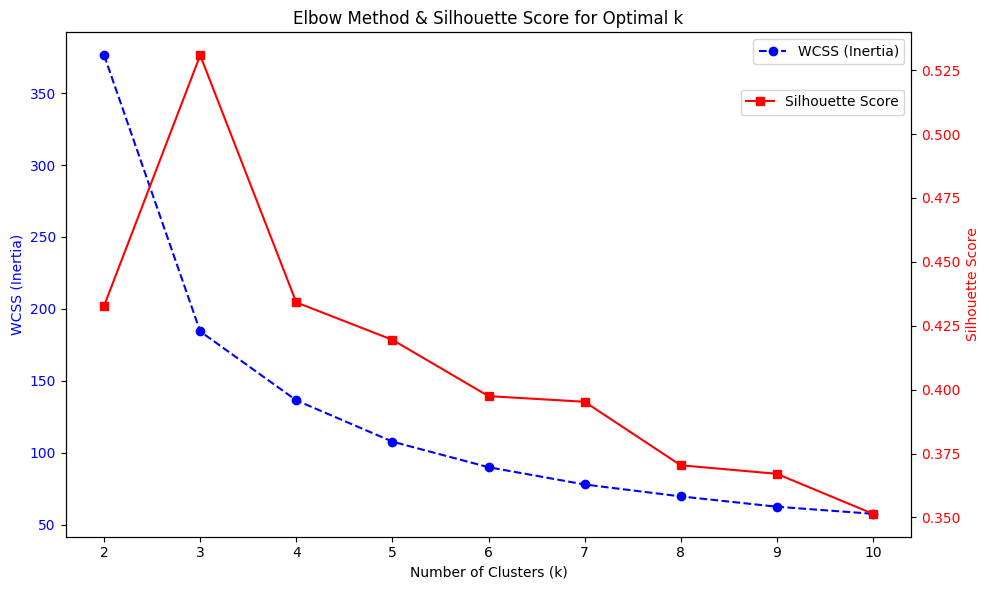

In [28]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

# Initialize lists to store WCSS and Silhouette Scores
wcss = []
silhouette_scores = []

# Define the range of cluster numbers to test (from 2 to 10 clusters)
K_range = range(2, 11)

# Iterate over different values of k to find the optimal number of clusters
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(df_embedded)
    wcss.append(kmeans.inertia_)

    # Calculate Silhouette Score only if k > 1
    silhouette_avg = silhouette_score(df_embedded, kmeans.labels_)
    silhouette_scores.append(silhouette_avg)

# Create figure and axis
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot WCSS (Elbow Method)
ax1.plot(K_range, wcss, 'bo--', label='WCSS (Inertia)')
ax1.set_xlabel('Number of Clusters (k)')
ax1.set_ylabel('WCSS (Inertia)', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Create a second y-axis for Silhouette Score
ax2 = ax1.twinx()
ax2.plot(K_range, silhouette_scores, 'rs-', label='Silhouette Score')
ax2.set_ylabel('Silhouette Score', color='red')
ax2.tick_params(axis='y', labelcolor='red')

# Title and Legends
plt.title('Elbow Method & Silhouette Score for Optimal k')
ax1.legend(loc='upper right')
ax2.legend(loc='upper right', bbox_to_anchor=(1, 0.9))

# Show plot
plt.tight_layout()
plt.show()


In [14]:
!pip install kneed

Best BIRCH threshold (highest Silhouette Score): 0.30000000000000004


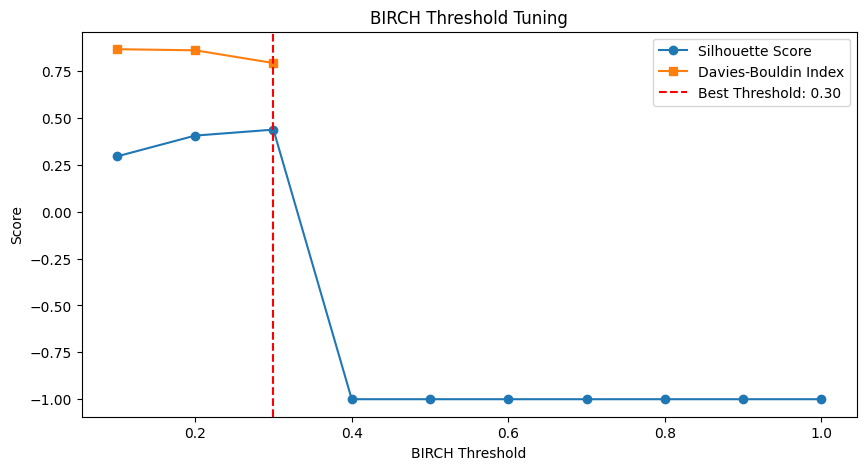

In [29]:
from sklearn.cluster import Birch
from sklearn.metrics import silhouette_score, davies_bouldin_score

# Define a range of thresholds to test
thresholds = np.linspace(0.1, 1.0, 10)  # Test 10 threshold values

# Store evaluation metrics
silhouette_scores = []
davies_bouldin_scores = []

# Evaluate BIRCH for different thresholds
for thresh in thresholds:
    birch = Birch(threshold=thresh, n_clusters=None)
    labels = birch.fit_predict(df_embedded)

    # Ensure multiple clusters exist before evaluating
    if len(set(labels)) > 1:
        silhouette_scores.append(silhouette_score(df_embedded, labels))
        davies_bouldin_scores.append(davies_bouldin_score(df_embedded, labels))
    else:
        silhouette_scores.append(-1)  # Invalid clustering
        davies_bouldin_scores.append(np.inf)  # Invalid clustering

# Find the best threshold
best_threshold = thresholds[np.argmax(silhouette_scores)]
print(f"Best BIRCH threshold (highest Silhouette Score): {best_threshold}")

# Plot results
plt.figure(figsize=(10, 5))
plt.plot(thresholds, silhouette_scores, marker='o', label="Silhouette Score")
plt.plot(thresholds, davies_bouldin_scores, marker='s', label="Davies-Bouldin Index")
plt.axvline(x=best_threshold, color='r', linestyle="--", label=f"Best Threshold: {best_threshold:.2f}")
plt.xlabel("BIRCH Threshold")
plt.ylabel("Score")
plt.title("BIRCH Threshold Tuning")
plt.legend()
plt.show()



In [30]:
from sklearn.cluster import SpectralClustering, DBSCAN, Birch, KMeans
from sklearn.mixture import GaussianMixture

# Clustering Algorithms
clustering_algorithms = {
    "K-Means++": KMeans(n_clusters=3, init='k-means++', random_state=42, n_init=10),
    "Spectral Clustering": SpectralClustering(n_clusters=3, affinity='rbf', random_state=42),
    "BIRCH": Birch(n_clusters=3, threshold=0.3),
    "Gaussian Mixture Model": GaussianMixture(n_components=3, random_state=42),
}



In [31]:
# Compute Clustering Results
cluster_results = {}
validation_scores = {}

# Fit each clustering model and store results
for name, algorithm in clustering_algorithms.items():
    # Fit sklearn-compatible models with original features
    labels = algorithm.fit_predict(df_embedded)
    cluster_results[name] = labels  # Store cluster labels

# Now iterate over cluster_results (which is no longer empty)
for name, labels in cluster_results.items():
    unique_labels = set(labels)
    print(f"{name} - Unique Clusters Found: {len(unique_labels)}")


K-Means++ - Unique Clusters Found: 3
Spectral Clustering - Unique Clusters Found: 3
BIRCH - Unique Clusters Found: 3
Gaussian Mixture Model - Unique Clusters Found: 3


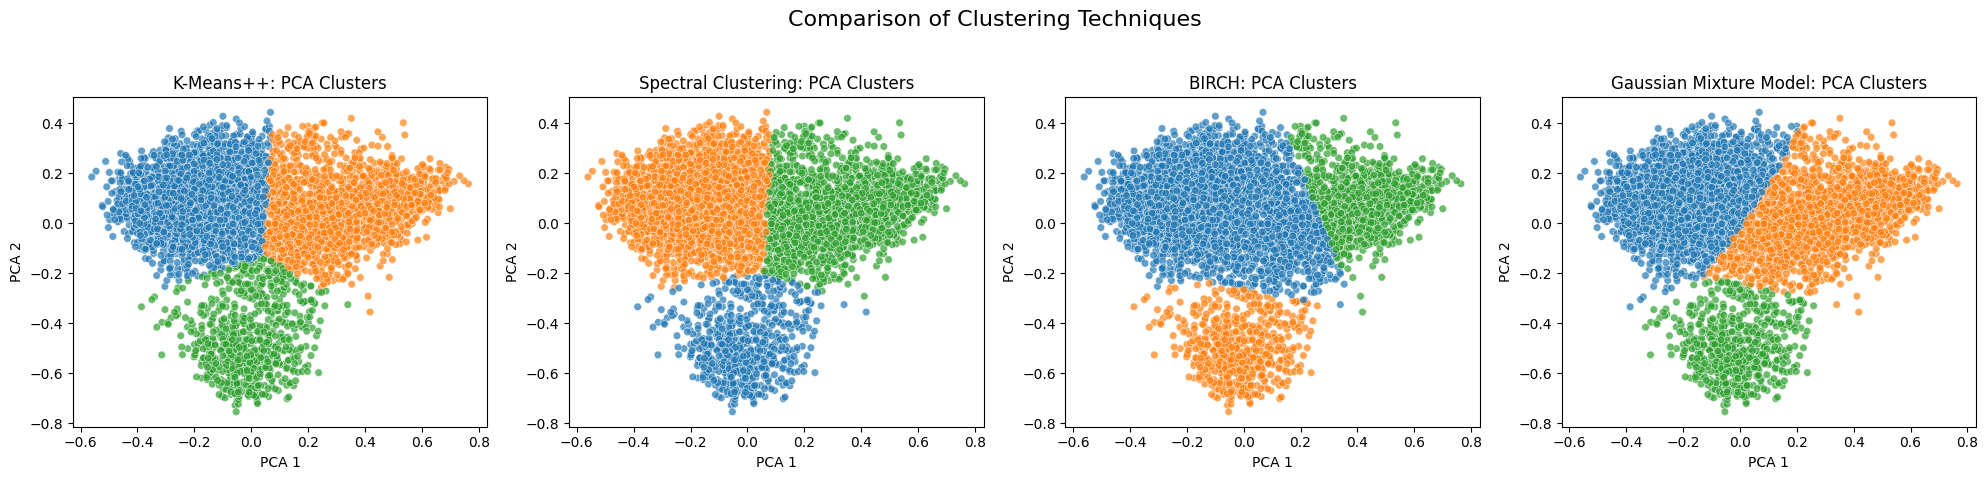

In [32]:
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Store validation scores in a dictionary
validation_scores = {}

for name, labels in cluster_results.items():
    data = df_embedded

    # Compute clustering validation metrics only if there is more than one cluster
    if len(set(labels)) > 1:  # Silhouette Score requires at least 2 clusters
        silhouette = silhouette_score(data, labels)
    else:
        silhouette = -1  # Assign -1 when only one cluster exists to avoid errors

    # Compute Davies-Bouldin Index (lower is better)
    db_index = davies_bouldin_score(data, labels)

    # Compute Calinski-Harabasz Index (higher is better)
    ch_index = calinski_harabasz_score(data, labels)

    # Store validation scores
    validation_scores[name] = {
        "Silhouette Score": silhouette,
        "Davies-Bouldin Index": db_index,
        "Calinski-Harabasz Index": ch_index
    }

# Get the number of clustering methods used
num_clusters = len(cluster_results)

# Create subplots with 1 row and num_clusters columns
fig, axes = plt.subplots(1, num_clusters, figsize=(5 * num_clusters, 5))
fig.suptitle("Comparison of Clustering Techniques", fontsize=16)

# If only one clustering method exists, make sure axes is a list
if num_clusters == 1:
    axes = [axes]

# Iterate through the clustering results and visualize the clusters
for i, (name, labels) in enumerate(cluster_results.items()):
    unique_labels = len(set(labels))  # Get number of unique clusters
    palette = sns.color_palette("tab10", n_colors=unique_labels)  # Define color palette

    x = data["PC1"]
    y = data["PC2"]

    # Scatter plot for visualizing clustering
    sns.scatterplot(
        x=x,
        y=y,
        hue=labels,  # Color clusters by labels
        palette=palette,
        alpha=0.7,
        s=30,
        ax=axes[i]
    )

    # Set plot title and axis labels
    axes[i].set_title(f"{name}: PCA Clusters")
    axes[i].set_xlabel("PCA 1")
    axes[i].set_ylabel("PCA 2")

    # Remove legends from each subplot to avoid redundancy
    axes[i].legend([], frameon=False)

# Adjust layout to prevent overlapping labels
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

# Display the plots
plt.show()


In [33]:
# Convert validation scores to DataFrame
validation_df = pd.DataFrame(validation_scores).T

# Print the validation scores
validation_df

,Silhouette Score,Davies-Bouldin Index,Calinski-Harabasz Index
K-Means++,0.530818,0.627562,6856.302561
Spectral Clustering,0.531729,0.623586,6784.000571
BIRCH,0.463894,0.637400,4654.678349
Gaussian Mixture Model,0.519691,0.651127,6309.655584
